In [9]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


In [4]:
from pubval import PubChemValidator
pcv = PubChemValidator(None, None, None)

/Users/lmar3213/miniconda3/envs/lew_conda/lib/python3.7/site-packages/lightfm/_lightfm_fast.py:9: UserWarning: LightFM was compiled without OpenMP support. Only a single thread will be used.
  warnings.warn('LightFM was compiled without OpenMP support. '


In [708]:
pcv.load_checkpoint()
print(len(pcv.predictions))

23872


In [709]:
import tqdm
import pandas as pd

df = pd.DataFrame(columns=['tid', 'pref_name', 'lig_chemblid', 'aid', 'outcome', 'title','nnrank'])
count = 0 
acts = list()

inacts= list()
probs= list()
nns = list()
for pred in tqdm.tqdm_notebook(pcv.predictions.keys()):
    lig, targ = pred.split(':')
    try:
        target_synonyms = pcv.targets[targ]['synonyms']
        tid = pcv.targets[targ]['tid']
        pref_name = pcv.targets[targ]['pref_name']
        
        ligand_chemblid = pcv.ligands[lig]['chemblid']
    
        assays = pcv.ligands[lig]['assays']
    except:
        continue
        
    act = 0
    inact = 0
    unspec = 0
    
    nn = pcv.predictions[pred]['nn']
    
    
    for a in assays:
        aid = a[0]
        title = a[2]
        clean_title = pcv.clean_text(title)

        
        num = len(set(target_synonyms).intersection(clean_title.split()))
        if num>0:
            outcome =  a[1]
            if outcome=='Unspecified':
                unspec+=1
            if outcome=='Active':
                #print(aid, clean_title, target_synonyms)
                act+=1
            if outcome=='Inactive':
                inact+=1
            if outcome in ['Active', 'Inactive']:
                df.loc[count] = [tid, pref_name, ligand_chemblid, aid, outcome, title, nn]
                count+=1
    if sum([act, inact])>0:
        prob = pcv.predictions[pred]['prob']
        
        nns.append(nn)
        acts.append(act)
        inacts.append(inact)
        probs.append(float(prob))
        
        #print( act, inact, prob)#, unspec ) 
        
acts = np.array(acts)
inacts = np.array(inacts)
nns =np.array(nns)
probs = np.array(probs)

/Users/lmar3213/miniconda3/envs/lew_conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # This is added back by InteractiveShellApp.init_path()


In [710]:
print(len(inacts))

674


In [711]:
df.sort_values(by='pref_name').to_csv('results.csv')

In [712]:
df

,tid,pref_name,lig_chemblid,aid,outcome,title,nnrank
0,CHEMBL261,Carbonic anhydrase I,CHEMBL2326507,727274,Inactive,inhibition of full length human recombinant fu...,1.5
1,CHEMBL222,Norepinephrine transporter,CHEMBL3126751,1075730,Active,displacement of [3h]nisoxetine from sprague da...,11.5
2,CHEMBL261,Carbonic anhydrase I,CHEMBL215355,271037,Active,inhibition of human cloned ca1 by co2 hydratio...,1.0
3,CHEMBL321,Matrix metalloproteinase 9,CHEMBL43147,310906,Active,inhibition of mmp9,1.0
4,CHEMBL333,Matrix metalloproteinase-2,CHEMBL348335,107154,Active,inhibitory activity against human gelatinase a...,3.0
...,...,...,...,...,...,...,...
1466,CHEMBL2147,Serine/threonine-protein kinase PIM1,CHEMBL14762,256650,Inactive,average binding constant for pim1 nanot active...,69.0
1467,CHEMBL239,Peroxisome proliferator-activated receptor alpha,CHEMBL524829,348373,Active,displacement of radiolabeled ligand from human...,1.0
1468,CHEMBL239,Peroxisome proliferator-activated receptor alpha,CHEMBL524829,665203,Active,agonist activity at pparalpha,1.0
1469,CHEMBL279,Vascular endothelial growth factor receptor 2,CHEMBL3653137,1258178,Active,lanthascreen tr fret assay: the assay has been...,36.0


In [713]:
piv = df.pivot_table(index=['pref_name','lig_chemblid'], columns='outcome', aggfunc='size', fill_value=0)


In [714]:
n,x = np.histogram((piv['Active'] - piv['Inactive']).values, bins=100)

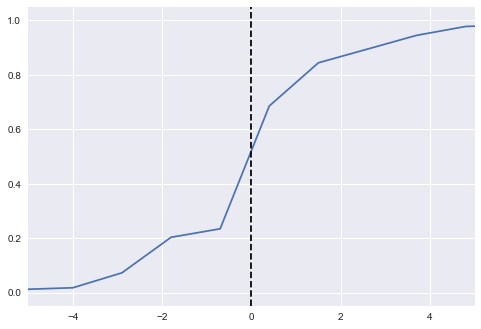

In [715]:
plt.plot(x[:-1], np.cumsum(n) / sum(n))
plt.xlim(-5,5)
plt.axvline(0, c='k', linestyle='--')

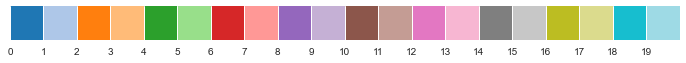

In [716]:
from matplotlib import colors
def makeCmap(name, color_nums):
    cmap = plt.get_cmap(name)
    cmap2 = colors.ListedColormap([cmap.colors[i] for i in color_nums])
    #bounds=[i for i in range(len(color_nums))]
    #norm = colors.BoundaryNorm(bounds, cmap2.N)
    
    return cmap2#, norm
def view_colormap(cmap):
    """Plot a colormap"""
    cmap = plt.cm.get_cmap(cmap)
    colors = cmap(np.arange(cmap.N))
    
    
    fig, ax = plt.subplots(1, figsize=(12, 3),
                           subplot_kw=dict(xticks=range(len(colors)), yticks=[]))
    ax.imshow([colors], extent=[0, len(colors), 0, 1])

    
view_colormap('tab20')

In [717]:
cm = makeCmap('tab20', [1, 2, 4])

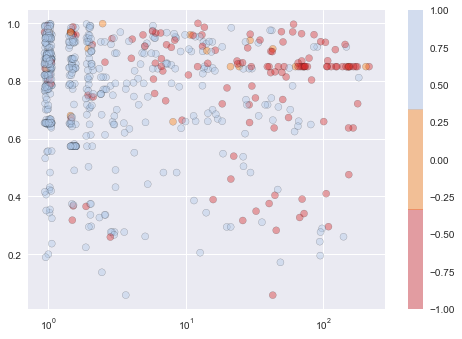

In [718]:
cm = makeCmap('tab20', [6, 2, 1])
jit = np.random.random(len(nns))-0.5
jit /= 8
jit += 1
plt.scatter(nns*jit, 
            probs, 
            c=np.sign(acts-inacts), 
            alpha=0.4, 
            edgecolor='k',
            cmap=cm
           )
plt.colorbar()
plt.xscale('log')

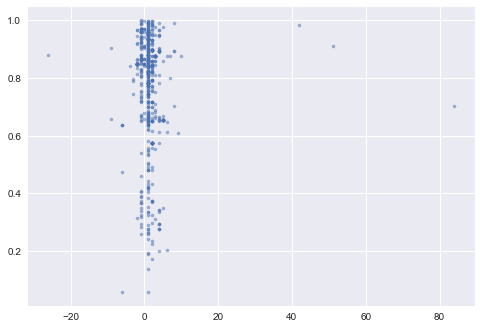

In [719]:
plt.scatter(np.array(acts) - np.array(inacts), 
            [float(i) for i in probs],
           s=10,
           alpha=0.5)

In [720]:
d =np.vstack([np.array(acts),np.array(inacts)])

In [721]:
p = list()
n = list()
checks = np.arange(1,200)
for rank in checks:
    mask = nns>rank

    m = d.T[mask]
    res = (m[:,0] - m[:,1])

    
    p.append((res>0).sum())
    n.append((res<0).sum())
    print(f'RANK:{rank}')
    print('\t', (res>0).sum())
    print('\t',(res<0).sum())

RANK:1
	 288
	 124
RANK:2
	 159
	 112
RANK:3
	 123
	 109
RANK:4
	 111
	 107
RANK:5
	 100
	 105
RANK:6
	 89
	 100
RANK:7
	 85
	 94
RANK:8
	 80
	 92
RANK:9
	 75
	 91
RANK:10
	 74
	 90
RANK:11
	 70
	 89
RANK:12
	 66
	 89
RANK:13
	 65
	 85
RANK:14
	 54
	 84
RANK:15
	 51
	 83
RANK:16
	 47
	 82
RANK:17
	 46
	 82
RANK:18
	 44
	 81
RANK:19
	 42
	 80
RANK:20
	 41
	 79
RANK:21
	 40
	 78
RANK:22
	 39
	 78
RANK:23
	 39
	 77
RANK:24
	 39
	 76
RANK:25
	 37
	 75
RANK:26
	 37
	 74
RANK:27
	 34
	 73
RANK:28
	 31
	 70
RANK:29
	 30
	 70
RANK:30
	 28
	 67
RANK:31
	 28
	 67
RANK:32
	 28
	 66
RANK:33
	 27
	 66
RANK:34
	 27
	 65
RANK:35
	 27
	 64
RANK:36
	 25
	 64
RANK:37
	 24
	 63
RANK:38
	 24
	 63
RANK:39
	 24
	 63
RANK:40
	 24
	 63
RANK:41
	 22
	 63
RANK:42
	 21
	 61
RANK:43
	 21
	 58
RANK:44
	 19
	 56
RANK:45
	 18
	 55
RANK:46
	 17
	 53
RANK:47
	 17
	 53
RANK:48
	 17
	 51
RANK:49
	 17
	 49
RANK:50
	 16
	 48
RANK:51
	 16
	 48
RANK:52
	 16
	 47
RANK:53
	 16
	 47
RANK:54
	 16
	 47
RANK:55
	 16
	 45
RANK:56


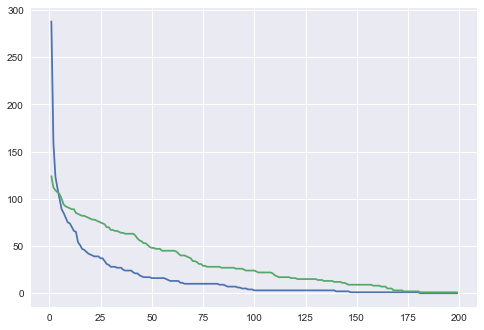

In [722]:
plt.plot(checks, p)
plt.plot(checks, n)

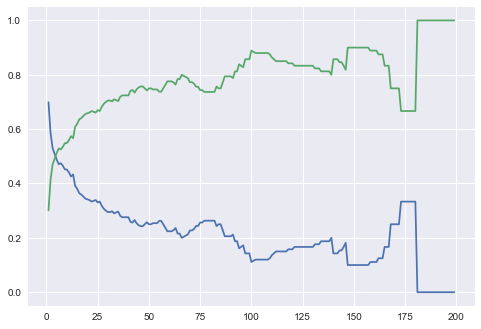

In [723]:
plt.plot(checks, 
         np.array(p) / (np.array(p)+np.array(n)))

plt.plot(checks, 
         np.array(n) / (np.array(p)+np.array(n)))

In [724]:
from scipy.stats import beta
plt.style.use('seaborn')

(0.0, 1.0)

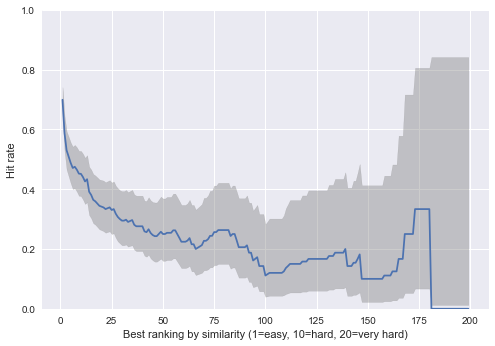

In [725]:

rate = np.array(p) / (np.array(p) + np.array(n))
low = beta.ppf(0.025, np.array(p)+1, np.array(n)+1)
high =beta.ppf(0.975, np.array(p)+1, np.array(n)+1)
plt.fill_between(x=checks,y1=low, y2=high,alpha=0.4, color='grey')
plt.plot(checks, rate)

plt.ylabel('Hit rate')
plt.xlabel('Best ranking by similarity (1=easy, 10=hard, 20=very hard)')
plt.ylim(0,1)

# #rate = np.array(n) / (np.array(p) + np.array(n))
# rate = 1-rate
# #low = beta.ppf(0.025, np.array(n)+1, np.array(p)+1)
# #high =beta.ppf(0.975, np.array(n)+1, np.array(p)+1)
# plt.fill_between(x=checks,y1=1-low, y2=1-high,alpha=0.4, color='grey')
# plt.plot(checks, rate)

# rate = np.array(p) / (np.array(p) + np.array(n))

<BarContainer object of 16 artists>

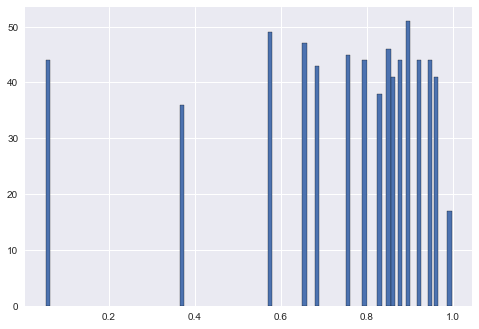

In [726]:
#nbin = 6
#n,x= np.histogram(probs,bins=nbin)
#nbin=6
#n,x=np.histogram(probs, bins=np.linspace(0,1,nbin+1))
n, x = np.histogram(probs, bins=list(probs[probs.argsort()][::len(probs)//15])+[1])

#n, x = np.histogram(probs, bins=bayesian_blocks(probs))
plt.bar(x[:-1], n,edgecolor='k', width=0.01)

Text(0, 0.5, 'Hit rate')

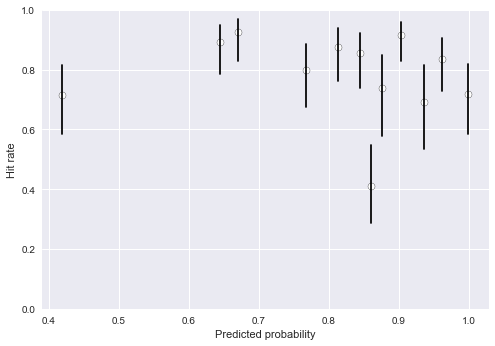

In [727]:
#digits = np.digitize(probs,x)

stride = 12
x = probs[probs.argsort()][::len(probs)//stride]
digits = np.digitize(probs,x)
nbin=len(x)
for b in range(1,nbin):
#for b in range(1,len(x[:-1])):
    mask = digits==b
    
    pos = ((d[0] - d[1])>0)[mask].sum()
    neg = ((d[0] - d[1])<0)[mask].sum()
    
    low = beta.ppf(0.025, pos+1, neg+1)
    high = beta.ppf(0.975, pos+1, neg+1)
    #print(pos/(pos+neg), low, high)
    
    plt.plot([ x[b], x[b]], [low, high], c='k')
    
    plt.scatter([x[b]], [pos/(pos+neg)],edgecolor = 'k', facecolor='white')
    
plt.ylim(0,1)
plt.xlabel('Predicted probability')
plt.ylabel('Hit rate')

### 

In [728]:
df

,tid,pref_name,lig_chemblid,aid,outcome,title,nnrank
0,CHEMBL261,Carbonic anhydrase I,CHEMBL2326507,727274,Inactive,inhibition of full length human recombinant fu...,1.5
1,CHEMBL222,Norepinephrine transporter,CHEMBL3126751,1075730,Active,displacement of [3h]nisoxetine from sprague da...,11.5
2,CHEMBL261,Carbonic anhydrase I,CHEMBL215355,271037,Active,inhibition of human cloned ca1 by co2 hydratio...,1.0
3,CHEMBL321,Matrix metalloproteinase 9,CHEMBL43147,310906,Active,inhibition of mmp9,1.0
4,CHEMBL333,Matrix metalloproteinase-2,CHEMBL348335,107154,Active,inhibitory activity against human gelatinase a...,3.0
...,...,...,...,...,...,...,...
1466,CHEMBL2147,Serine/threonine-protein kinase PIM1,CHEMBL14762,256650,Inactive,average binding constant for pim1 nanot active...,69.0
1467,CHEMBL239,Peroxisome proliferator-activated receptor alpha,CHEMBL524829,348373,Active,displacement of radiolabeled ligand from human...,1.0
1468,CHEMBL239,Peroxisome proliferator-activated receptor alpha,CHEMBL524829,665203,Active,agonist activity at pparalpha,1.0
1469,CHEMBL279,Vascular endothelial growth factor receptor 2,CHEMBL3653137,1258178,Active,lanthascreen tr fret assay: the assay has been...,36.0


# Plotting:

In [729]:
def parse_group(group):
    inactive = group['outcome'].str.contains('Inactive').any()
    active = group['outcome'].str.contains('Active').any()
    if inactive and active:
        return 'Both'
    elif active and ~inactive:
        return 'Active'
    elif inactive and ~active:
        return 'Inactive'
    else:
        return False
    
def parse_group2(group):
    inactive = group['outcome'].str.contains('Inactive').sum()
    active = group['outcome'].str.contains('Active').sum()
    if (active - inactive) > 0:
        return 'Active'
    if (active - inactive) < 0:
        return 'Inactive'
    else:
        return 'Both'
    
    
#Mask 1-NN solutions:
#out = df[df['nnrank']>0].groupby(['lig_chemblid', 'pref_name']).apply(parse_group2)

#remove enzymes (anything with 'ase' in it)
out = df[~df['pref_name'].str.contains('ase')].groupby(['lig_chemblid', 'pref_name']).apply(parse_group2)

out_df= pd.DataFrame(out).reset_index().drop('lig_chemblid',axis=1)
out_df.columns=['pref_name', 'activity']

In [730]:
res = piv.reset_index()
res['result'] = np.sign(res['Active'] - res['Inactive'])

In [731]:
res.groupby('pref_name')['result'].sum()

pref_name
3-phosphoinositide dependent protein kinase-1     1
ADAM17                                           -1
Acetylcholinesterase                              4
Alpha-1d adrenergic receptor                      3
Androgen Receptor                                 1
                                                 ..
Tyrosine-protein kinase receptor FLT3            28
Vascular endothelial growth factor receptor 1     0
Vascular endothelial growth factor receptor 2    42
c-Jun N-terminal kinase 1                        -2
c-Jun N-terminal kinase 3                        -1
Name: result, Length: 91, dtype: int64

In [732]:
import altair as alt


In [733]:
temp = out_df.groupby('pref_name').filter(lambda x : len(x)>1)
ch = alt.Chart(temp).mark_bar()

# ch = ch.encode(
#     x = alt.X('pref_name', sort='-y', title='Target preferred name'),
#     y = alt.Y('count()'),
#     color=alt.Color('activity'),
#     order=alt.Order('activity', sort='ascending'),
# )

ch = ch.encode(
    y = alt.Y('pref_name', sort='-x', title='Target preferred name'),
    x = alt.X('count()', title='Count'),
    color=alt.Color('activity'),
    order=alt.Order('activity', sort='ascending'),
    tooltip=['count()',]
).properties(height=850,width=400)

ch.configure_axisY(
titleFontSize=13,
).configure_axisX(
titleFontSize=13
).configure_axisBottom(labelAngle=-35).configure_header(
    titleFontSize=40, 
    labelFontSize=40
).configure_axisY(
    titleAngle=0,
    titleAlign="left",
    titleY=-10,
    titleX=-20,
    titleFontSize=16,
).configure_legend(orient='bottom',labelFontSize=22)

ch.interactive()

alt.Chart(...)

In [702]:
temp = out_df.groupby('pref_name').filter(lambda x : len(x)>2)
ch = alt.Chart(temp).mark_bar()

# ch = ch.encode(
#     x = alt.X('pref_name', sort='-y', title='Target preferred name'),
#     y = alt.Y('count()'),
#     color=alt.Color('activity'),
#     order=alt.Order('activity', sort='ascending'),
# )

ch = ch.encode(
    y = alt.Y('pref_name', sort='-x', title='Target preferred name'),
    x = alt.X('count()', title='Count'),
    color=alt.Color('activity'),
    order=alt.Order('activity', sort='ascending'),
).properties(height=500,width=300)

# ch.configure_axisY(
# titleFontSize=13,
# ).configure_axisX(
# titleFontSize=13
# ).configure_axisBottom(labelAngle=-35).configure_header(
#     titleFontSize=40, 
#     labelFontSize=40
# ).configure_axisY(
#     titleAngle=0,
#     titleAlign="left",
#     titleY=-10,
#     titleX=-20,
#     titleFontSize=16,
# ).configure_legend(orient='bottom',labelFontSize=22)

ch

alt.Chart(...)

In [649]:
ch = alt.Chart(out_df).mark_bar()

ch = ch.encode(
    x = alt.X('pref_name', sort='-y', title='Target preferred name'),
    y = alt.Y('count()'),
    color=alt.Color('activity'),
    order=alt.Order('activity', sort='ascending'),
).properties(height=200,width=750)
ch



alt.Chart(...)